<a href="https://colab.research.google.com/github/VoltronOP/ML-projects/blob/main/Image_Cartoonization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import tensorflow
print(tensorflow.__version__)

1.15.2


In [3]:
print("Amaan Ali Khan ")
print("181112011")
print("Cse 1")

Amaan Ali Khan 
181112011
Cse 1


In [4]:
import os
import cv2
import numpy as np
import tensorflow as tf
import network
import guided_filter
from tqdm import tqdm
from IPython.display import Image

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [5]:
def resize_crop(image):
    h, w, c = np.shape(image)
    if min(h, w) > 720:
        if h > w:
            h, w = int(720*h/w), 720
        else:
            h, w = 720, int(720*w/h)
    image = cv2.resize(image, (w, h),
                      interpolation=cv2.INTER_AREA)
    h, w = (h//8)*8, (w//8)*8
    image = image[:h, :w, :]
    return image

In [6]:
def cartoonize(load_folder, save_folder, model_path):
    input_photo = tf.placeholder(tf.float32, [1, None, None, 3])
    network_out = network.unet_generator(input_photo)
    final_out = guided_filter.guided_filter(input_photo, network_out, r=1, eps=5e-3)

    all_vars = tf.trainable_variables()
    gene_vars = [var for var in all_vars if 'generator' in var.name]
    saver = tf.train.Saver(var_list=gene_vars)
    
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)

    sess.run(tf.global_variables_initializer())
    saver.restore(sess, tf.train.latest_checkpoint(model_path))
    name_list = os.listdir(load_folder)
    for name in tqdm(name_list):
        try:
            load_path = os.path.join(load_folder, name)
            save_path = os.path.join(save_folder, name)
            image = cv2.imread(load_path)
            image = resize_crop(image)
            batch_image = image.astype(np.float32)/127.5 - 1
            batch_image = np.expand_dims(batch_image, axis=0)
            output = sess.run(final_out, feed_dict={input_photo: batch_image})
            output = (np.squeeze(output)+1)*127.5
            output = np.clip(output, 0, 255).astype(np.uint8)
            cv2.imwrite(save_path, output)
        except:
            print('cartoonize {} failed'.format(load_path))

In [7]:
model_path = 'saved_models'
load_folder = 'test_images'
save_folder = 'cartoonized_images'

In [8]:
if not os.path.exists(save_folder):
    os.mkdir(save_folder)
cartoonize(load_folder, save_folder, model_path)



Instructions for updating:
Please use `layer.__call__` method instead.

INFO:tensorflow:Restoring parameters from saved_models/model-33999


100%|██████████| 3/3 [00:14<00:00,  4.87s/it]


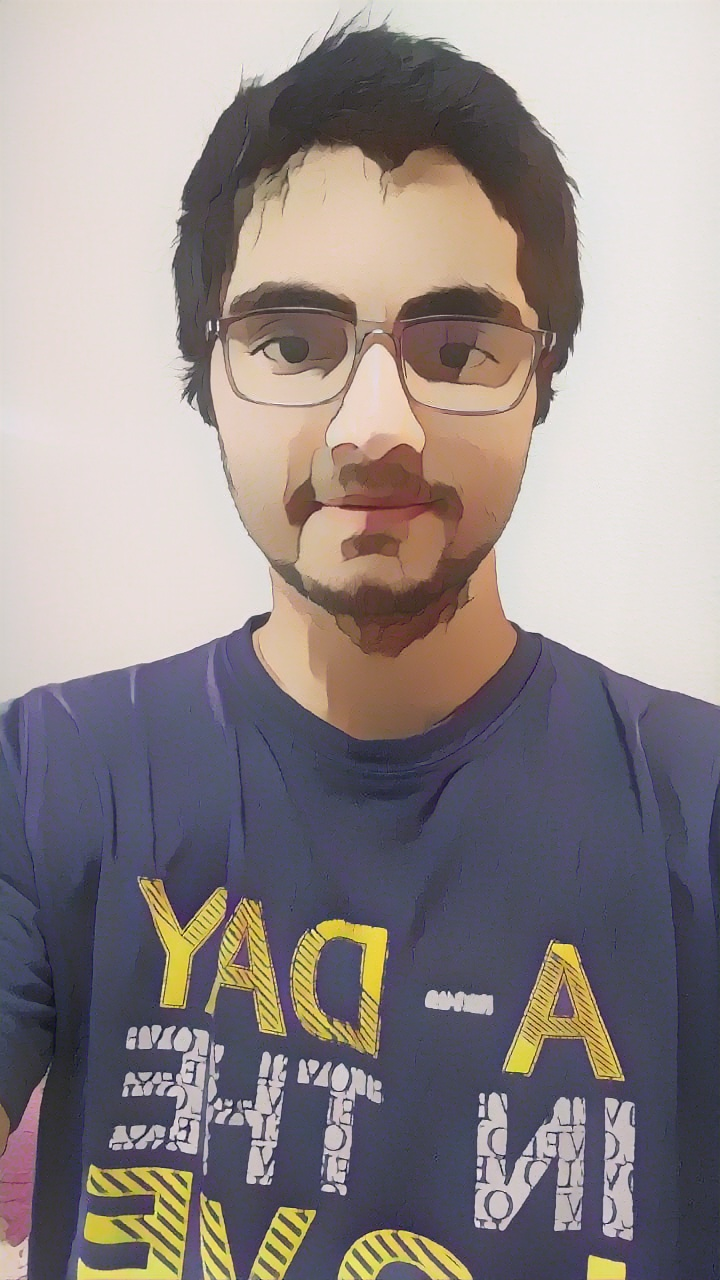

In [10]:
Image("cartoonized_images/6.jpg")

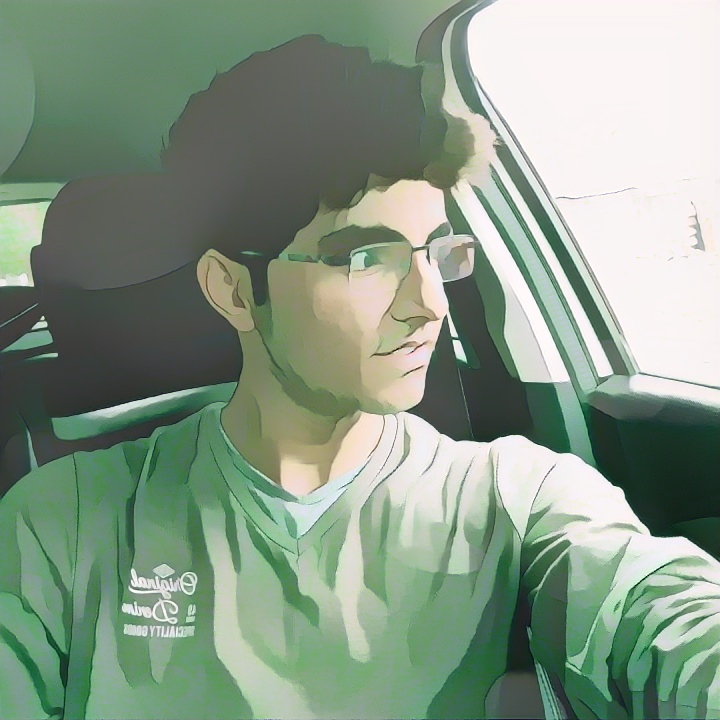

In [11]:
Image("cartoonized_images/7.jpg")

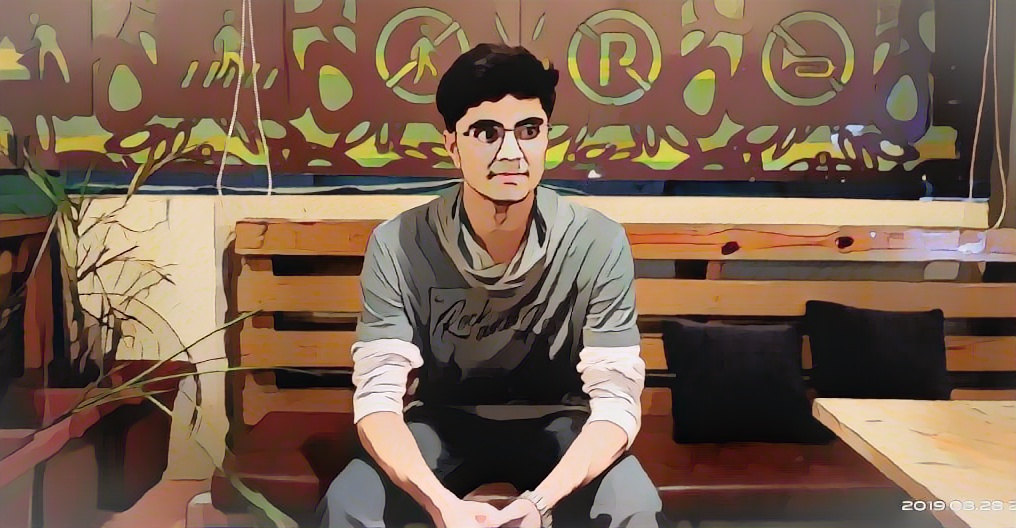

In [12]:
Image("cartoonized_images/8.jpg")